In [1]:
import json
import os
import os.path as path
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def parse(dirname, num_joints=15):
    filenames = sorted(glob.glob(path.join(dirname, '*.json')))
    poses = np.zeros([len(filenames), num_joints, 2])
    confidences = np.zeros([len(filenames), num_joints])
    prev_pose = None
    missed_detections = 0

    for i, filename in enumerate(filenames):
        with open(filename) as json_file:
            people = json.load(json_file)['people']
        if len(people) == 0:
            missed_detections += 1
            pose = poses[i-1, :]
        else:
            points = np.array(people[0]['pose_keypoints_2d']).reshape(-1, 3)[:num_joints]
            pose = -points[:, :2]
            confidence = points[:, -1]
            confidences[i, :] = confidence

        prev_pose = pose if prev_pose is None else prev_pose
        poses[i] = pose
        poses[i, confidences[i] < 0.25] = prev_pose[confidences[i] < 0.25]
        prev_pose = poses[i]
    return poses

In [3]:
first = parse("output/videos/temp0.mp4")
print(len(first))

4861


In [4]:
class PoseDataset(Dataset):
    def __init__(self, directory):
        self.dirnames = sorted(glob.glob(path.join(directory, '*.mp4')))
    def __getitem__(self, index):
        return parse(self.dirnames[index])
    def __len__(self):
        return len(self.dirnames)

In [5]:
data = PoseDataset("output/videos")
data_split = [np.array_split(y, len(y) // 30, 0)[1:-1] for y in data]
data_set = [item for sublist in data_split for item in sublist]
data_set = [x for x in data_set if x.shape[0] == 30]
pose_data = data

In [6]:
kmeans = KMeans(n_clusters=128)
kmeans.fit(np.stack(data_set).reshape(len(data_set), -1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=128, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
kmeans.cluster_centers_

array([[-295.3862027 , -129.32029865, -301.44498649, ..., -236.2232027 ,
        -278.13602703, -289.05168919],
       [-681.81169231, -293.74407692, -706.84069231, ..., -509.43146154,
        -780.40323077, -588.604     ],
       [-699.09986538, -264.33012564, -703.37459744, ..., -507.78755128,
        -805.91941026, -576.8885    ],
       ...,
       [ -51.3949    , -570.669     ,  -35.6967    , ..., -411.95      ,
        -304.227     , -447.179     ],
       [-310.13154569, -123.28053873, -309.1206879 , ..., -250.39396067,
        -322.49591528, -292.64096823],
       [-163.1745    , -652.9005    , -163.0835    , ..., -521.577     ,
        -978.172     , -609.813     ]])

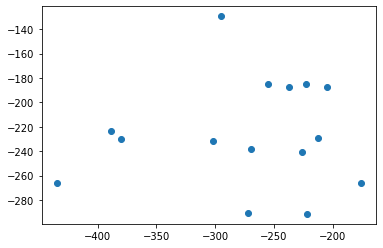

In [8]:
plt.scatter(kmeans.cluster_centers_[0].reshape(30, 15, 2)[0, :, 0], kmeans.cluster_centers_[0].reshape(30, 15, 2)[0, :, 1])

In [9]:
np.save("clusters.npy", kmeans.cluster_centers_)

In [20]:
new_data = [x[:1200] for x in pose_data]
new_data = [np.split(x, 40, 0) for x in new_data]
labels = np.stack([kmeans.predict(np.stack(x).reshape(40, 30*15*2)) for x in new_data])

In [21]:
np.save("labels.npy", labels)

In [22]:
import librosa
from librosa.core import load
from librosa.feature import melspectrogram, tempogram
from librosa.display import specshow

In [30]:
class MusicDataset(Dataset):
    def __init__(self, directory):
        super().__init__()
        self.path = directory
        self.files = sorted(glob.glob(path.join(directory, '*.wav')))
    def __getitem__(self, index):
        filename = self.files[index]
        wav = load(filename)[0]
        mel_spectrogram = melspectrogram(wav)
        tempo = tempogram(wav)
        merged = np.concatenate([mel_spectrogram, tempo], 0)
        scaled = np.log1p(merged)
        return scaled[:, :1200]
    def __len__(self):
        return len(self.files)

In [31]:
music_data = MusicDataset("audio")

In [32]:
from torch.utils.data import DataLoader
musics = [x for x in DataLoader(music_data, num_workers=16, batch_size=None)]

In [34]:
musics = [x[:, :1200] for x in musics]
print([x.shape for x in musics])
np.save("music.npy", np.stack(musics))

[torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]), torch.Size([512, 1200]),